# Regression model for snow depth in time lapse images

SnowEx Hackweek 2021 

*#cam_learning*

__Contributors:__ Marianne Cowherd, Danny Hogan, Katie Breen, Ching-ping Yu

### __Objectives:__

- Train a regression model for extracting snow depth from time-lapse imagery using supervised learning
- Evaluate model for accuracy 
- Test potential improvemnts (i.e. cropping images) and suggest ideas for next steps
- Learn ML!

### __Motivations:__

- 2020 SnowEx time-lapse imagery was labeled for snow-depth, but the process was time-consuming. 
- Automated methods exist using color thresholding and the Hough Transform, but background pixels add uncertainty.
- Computer vision may be able to detect the pole without including the background noise, and identify the snow depth information 
- 2017 SnowEx time-lapse has not been labeled, and a working ML model could be applied on these images

In [23]:
### insert moving video of all the camera images and snow depths underneath (Katie will add once she gets the code from Cassie)

### __Methods__

We will use the 2020 SnowEx timelapse from one camera (W1A) as our predictor and the corresponding snow depth measurements in the SnowEx SQL database as the response, to build a supervised model.

__1) Load packages for image and data table pre-processing, model development, and model evaluation__

In [24]:
# NOTE: this part of the tutorial uses additional libraries not in the default snowex jupyterhub
# mamba is a python package management alternative to conda and pip https://github.com/mamba-org/mamba
!mamba install -y -q tensorflow
!pip install opencv-python-headless 

In [25]:

#### Load packages for machine learning
import tensorflow as tf  # end-to-end open source platform for machine learning

# from tensorflow.keras.datasets import cifar10
# keras is python and uses tensorflow in the backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

#### Packages for image processing and computer vision 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import geopandas as gpd
import datetime as dt
from datetime import datetime

from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ExifTags

### Packages for processing snow depth values using the SnowEx SQL database 
from snowexsql.db import get_table_attributes

import snowexsql.db
from snowexsql.data import PointData, SiteData
from snowexsql.conversions import query_to_geopandas
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)


__2. After loading the packages, we will load in the images from the Amazon Web Services S3. We will focus on one camera, W1A.__ 

In [26]:
!aws s3 sync --no-progress s3://snowex-data/tutorial-data/camera-trap/ /tmp/camera-trap

In [27]:
## Load in the images 
files = os.listdir('/tmp/camera-trap/W1A')
files =  ['/tmp/camera-trap/W1A/' + str(f) for f in files]

df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])

for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]

__3. Read in the images using cv2's imread function, then downscale the images to 200 x 200 pixels. 'pixels' is a list of all the images represented as an RGB array.__

In [6]:
pixels = []      
for i in range(0, len(df)):
    # img = cv2.imread(str(path)+"/"+str(img))
    # src = Image.open(str(path)+"/"+str(img))
    path = df['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    #calculate the 50 percent of original dimensions
    width =200 # int(src.shape[1] * scale_percent / 100)
    height = 200 # int(src.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    # img1 = img.save('tmp', format='JPEG',dpi=(50,50))
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels.append(np.array(img2))

pixels = np.array(pixels)
print(pixels.shape) 
#print(pixels)
pixels=np.load('pixels_open.npy')

(659, 200, 200, 3)


FileNotFoundError: [Errno 2] No such file or directory: 'pixels_open.npy'

__4. Pull the snow depth values from the SnowEx SQL database__

In this case, we pulled all the data from the snow depth data from camera W1A.

In [7]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
# print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

# Grab the open site data from the db
open_site = 'W1A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Matach the time from the images to the depth in the database
df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    
df_open['datetime'] = [datetime.combine(df_open['date'][i],df_open['time'][i]).replace(tzinfo=None) for i in range(len(df_open))]


for i in range(len(df)):
    pivot = df['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df['depth'][i] = df_open['value'][idx]
  

<ipython-input-7-eaee364b886d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'][i] = df_open['value'][idx]


In [8]:
len(df.loc[df['depth']>0])

319

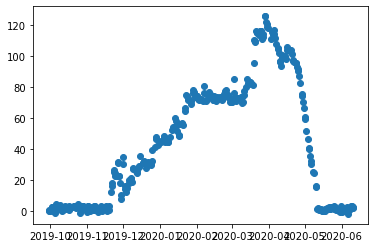

In [9]:
plt.plot(df['datetime'],df['depth'],'o')

__5. We will do the same as before but this time with cropped images. We will compare our results between the full images and the cropped images.__

We will collapse the code to save space. 

In [61]:
cropped_files = os.listdir('/data/cropped/W1A')
cropped_files =  ['/data/cropped/W1A' + str(f) for f in files]

df_cropped = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(cropped_files)): 
    
    cropped_img = Image.open(cropped_files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in cropped_img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df_cropped.loc[i]= [exif['DateTime'].date(),
                       cropped_files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
for i in range(len(df_cropped)):
    pivot = df_cropped['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df_cropped['depth'][i] = df_open['value'][idx]

pixels_cropped = []      
for i in range(0, len(df_cropped)):
    # img = cv2.imread(str(path)+"/"+str(img))
    # src = Image.open(str(path)+"/"+str(img))
    path = df_cropped['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    #calculate the 50 percent of original dimensions
    width =200 # int(src.shape[1] * scale_percent / 100)
    height = 200 # int(src.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    # img1 = img.save('tmp', format='JPEG',dpi=(50,50))
    cropped_img2 = cv2.imread('tmp.jpg')
    cropped_img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels_cropped.append(np.array(cropped_img2))

pixels_cropped = np.array(pixels_cropped)
pixels_cropped =np.load('pixels_cropped_open.npy')

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
# print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

# Grab the open site data from the db
open_site = 'W1A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Matach the time from the images to the depth in the database
df_cropped = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df_cropped.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    
df_open['datetime'] = [datetime.combine(df_open['date'][i],df_open['time'][i]).replace(tzinfo=None) for i in range(len(df_open))]


for i in range(len(df_cropped)):
    pivot = df_cropped['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df_cropped['depth'][i] = df_open['value'][idx]

FileNotFoundError: [Errno 2] No such file or directory: '/data/cropped/W1A'

__6. Flattening pixels data in a table.__

In [50]:
dataset = pixels.reshape((659,-1))
dataset = np.concatenate((dataset, np.array(df['depth']).reshape((659,1))),axis=1)
dataset = pd.DataFrame(dataset)
np.save('dataset_open.npy', dataset)

__7. Machine Learning Linear Regression.__

In [51]:
dataset = np.load('dataset_open.npy',allow_pickle=True)
dataset = dataset[dataset[:,-1]>0]

<ipython-input-51-c35e5314d888>:2: RuntimeWarning: invalid value encountered in greater
  dataset=dataset[dataset[:,-1]>0]


In [53]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [54]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_dataset)
scaled_test = scaler.transform(test_dataset) ## fit_transform != transform. 
                                             ## transform uses the parameters of fit_transform

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [55]:
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]

In [56]:
tf.random.set_seed(0) ## For reproducible results
linear_regression = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.  
linear_regression.add(tf.keras.layers.Dense(1, activation=None ,input_shape=(train_X.shape[1],)))
# Output layer has no activation with just 1 node

In [57]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
linear_regression.compile(optimizer = opt, loss='mean_squared_error')

In [58]:
print(linear_regression.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 120001    
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
%%time
# NOTE: can changed from epochs=150 to run faster, change to verbose=1 for per-epoch output
history =linear_regression.fit(train_X, train_y, epochs=100, validation_split = 0.2, verbose=0)

CPU times: user 1min 4s, sys: 1min 7s, total: 2min 11s
Wall time: 1min 6s


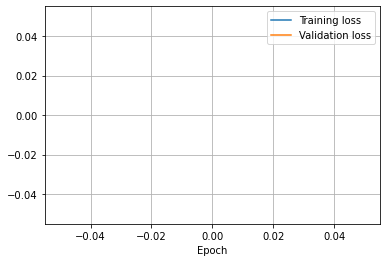

In [42]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)